In [1]:
import os
import yaml
import shutil
from tqdm import tqdm
from datetime import datetime

In [2]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

In [3]:
HOME = os.getcwd()

!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt

In [4]:
from ultralytics import YOLOv10
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

In [5]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
jupyterlab 4.2.3 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.

In [6]:
from roboflow import Roboflow
# dataset from https://universe.roboflow.com/david-glu/cotskaggle

ROBOFLOW_API_KEY = "rWU1eQHaSgCK3DzRY2TP"
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("david-glu").project("cotskaggle")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to COTSKaggle-1 in yolov8:: 100%|██████████| 18870/18870 [00:05<00:00, 3461.33it/s]


In [7]:
!cat COTSKaggle-1/data.yaml

names:
- json
nc: 1
roboflow:
  license: CC BY 4.0
  project: cotskaggle
  url: https://universe.roboflow.com/david-glu/cotskaggle/dataset/1
  version: 1
  workspace: david-glu
test: ../test/images
train: COTSKaggle-1/train/images
val: COTSKaggle-1/valid/images


In [8]:
!mkdir datasets/ 


In [9]:
!mv {HOME}/COTSKaggle-1 datasets/

In [10]:
# replace class 'json' to 'starfish' in data.yaml
DATASET_PATH = f'{HOME}/datasets/COTSKaggle-1/'

with open(DATASET_PATH + 'data.yaml', 'r') as f:
    data = yaml.safe_load(f)

data['names'] = ['starfish']
data['train'] = DATASET_PATH + 'train/images'
data['val'] = DATASET_PATH + 'valid/images'
data['test'] = DATASET_PATH +'test/images'

with open(DATASET_PATH + 'data.yaml', 'w') as file:
    yaml.dump(data, file, indent=4)

In [11]:
def label_path_to_bbox(label_path: str, normalized=True) -> list:
    with open(label_path, 'r') as file:
        # Read the content of the file
        file_content = file.read()
        
    detections = file_content.split('\n')
#     print(detections)
    str_boxes = [str_box.split(' ') for str_box in detections]
#     print(str_boxes)
    
    bboxes = []
    
    if normalized == False:
        image_path = label_path.replace('.txt','.jpg').replace( "labels", "images")
        image_width, image_height = Image.open(image_path).size
    
    for str_box in str_boxes:
        str_box_no_class = str_box[1:]
        float_box = [float(value) for value in str_box_no_class]
        
        if normalized == False:
            x_center = float_box[0] * image_width
            y_center = float_box[1] * image_height
            width = float_box[2] * image_width
            height = float_box[3] * image_height
            float_box = [x_center, y_center, width, height]
           
        bboxes.append(float_box)
        
    return bboxes    

In [12]:
def plot_image_with_bboxes(image, bboxes, normalized=True):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    # Display the image
    ax.imshow(image)
    # Get image dimensions
    image_width, image_height = image.size
    # Plot each bounding box
    for bbox in bboxes:
        if normalized == False:
            x_center = bbox[0]
            y_center = bbox[1]
            width = bbox[2]
            height = bbox[3]
        else:   
            x_center = bbox[0] * image_width
            y_center = bbox[1] * image_height
            width = bbox[2] * image_width
            height = bbox[3] * image_height
        
        # Calculate the top-left corner of the rectangle
        top_left_x = x_center - width / 2
        top_left_y = y_center - height / 2
        
        rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
#         ax.plot(x_center, y_center, 'ro')  # 'ro' means red color and circle marker

    plt.axis('off')
    plt.show()

In [13]:
def display_image_path_with_label_path(image_path, label_path):
    with open(label_path, 'r') as file:
        # Read the content of the file
        file_content = file.read()

    bboxes = label_path_to_bbox(label_path)

    # Load the image
    image = Image.open(image_path)
    
    # display images with annotations
    plot_image_with_bboxes(image, bboxes)

image path: /kaggle/working/datasets/COTSKaggle-1/train/images/1-5393_jpg.rf.731f24e52100e7850fe10a2bada225c1.jpg


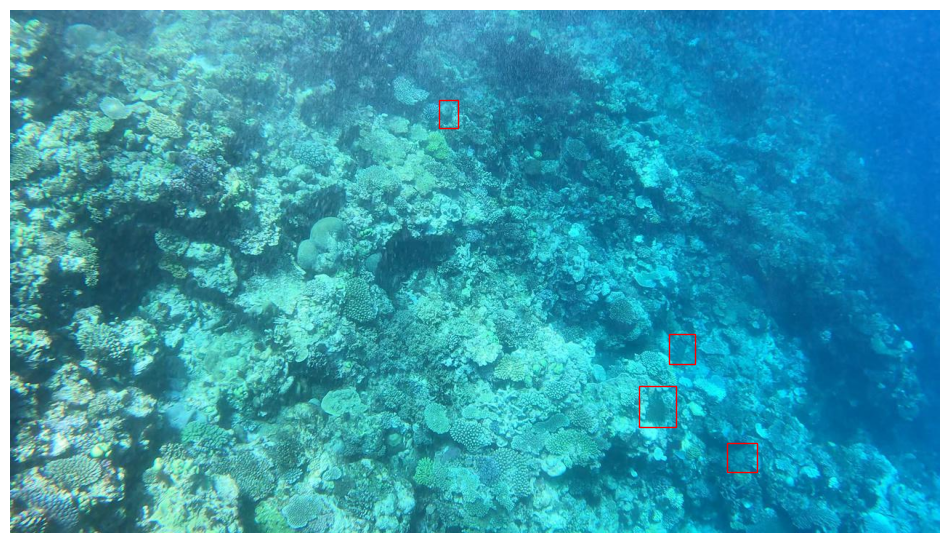

bbox: [[924.0, 466.0, 36.0, 42.0], [890.5, 545.5, 51.0, 57.0], [1007.0, 615.5, 42.0, 39.0], [603.0, 143.0, 26.0, 38.0]]
normalized bbox: [[0.721875, 0.6472222222222223, 0.028125, 0.058333333333333334], [0.695703125, 0.7576388888888889, 0.03984375, 0.07916666666666666], [0.78671875, 0.8548611111111111, 0.0328125, 0.05416666666666667], [0.47109375, 0.1986111111111111, 0.0203125, 0.05277777777777778]]


In [14]:
import random

IMAGE_PATH = DATASET_PATH + 'train/images'

train_images = os.listdir(IMAGE_PATH)

random_image = random.choice(train_images)
# print(random_image)
image_path = os.path.join(IMAGE_PATH, random_image)
label_path = image_path.replace("images", "labels").replace(".jpg", ".txt")
print(f"image path: {image_path}")

display_image_path_with_label_path(image_path, label_path)

print(f"bbox: {label_path_to_bbox(label_path, normalized=False)}")
print(f"normalized bbox: {label_path_to_bbox(label_path)}")

In [15]:
def xywh_to_xyxy(xywh_bboxes):
    """
    Convert bounding box from (x, y, width, height) to (x_min, y_min, x_max, y_max).

    Args:
        xywh (list or tuple): Bounding box in (x, y, width, height) format.

    Returns:
        list: Bounding box in (x_min, y_min, x_max, y_max) format.
    """
    xyxy_bboxes = []
    for xywh in xywh_bboxes:
        x, y, w, h = xywh
        x_min = x
        y_min = y
        x_max = x + w
        y_max = y + h
        xyxy_bboxes.append([x_min, y_min, x_max, y_max])
    return xyxy_bboxes

    


def xyxy_to_xywh(xyxy_bboxes):
    """
    Convert bounding box from (x_min, y_min, x_max, y_max) to (x, y, width, height).

    Args:
        xyxy (list or tuple): Bounding box in (x_min, y_min, x_max, y_max) format.

    Returns:
        list: Bounding box in (x, y, width, height) format.
    """
    xywh_bboxes = []
    for xyxy in xyxy_bboxes:
        x_min, y_min, x_max, y_max = xyxy
        x = x_min
        y = y_min
        width = x_max - x_min
        height = y_max - y_min
        xywh_bboxes.append([x, y, width, height])
    return xywh_bboxes

In [16]:
# import torch
# import torchvision.transforms as transforms
# import kornia
# import matplotlib.pyplot as plt
# from PIL import Image

# # Define Kornia augmentations
# augmentation_pipeline = kornia.augmentation.AugmentationSequential(
#     kornia.augmentation.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.9),
# #     data_keys=["input"]
# )

In [17]:
# # display random image after augmentation

# # Load the image
# train_images = os.listdir(IMAGE_PATH)

# random_image = random.choice(train_images)
# # print(random_image)
# image_path = os.path.join(IMAGE_PATH, random_image)
# label_path = image_path.replace("images", "labels").replace(".jpg", ".txt")
# print(label_path)
# image = Image.open(image_path)

# # Convert the image to a tensor
# transform = transforms.ToTensor()
# image_tensor = transform(image)

# # Example bounding boxes in the format (xmin, ymin, xmax, ymax)
# bboxes = label_path_to_bbox(label_path, normalized=False)
# # print(f"bbox xywh before aug: {bboxes}")
# # xyxy_bboxes = xywh_to_xyxy(bboxes)
# # xywh_bboxes_tensor = torch.tensor(bboxes, dtype=torch.float32)

# # Add batch dimension
# image_tensor = image_tensor.unsqueeze(0)

# # Apply the augmentations to the image and bounding boxes
# # augmented_image_tensor = augmentation_pipeline(image_tensor, xywh_bboxes_tensor)
# augmented_image_tensor = augmentation_pipeline(image_tensor)

# # Remove batch dimension for visualization
# augmented_image_tensor = augmented_image_tensor.squeeze(0)

# # Convert the tensor to a PIL image
# augmented_image = transforms.ToPILImage()(augmented_image_tensor)
# # augmented_bboxes = augmented_bboxes.tolist()

# # Display the original and augmented images with bounding boxes
# print(f"bbox before aug: {bboxes}")
# print("image before aug:")
# plot_image_with_bboxes(image, bboxes, normalized=False)

# # print(f"bbox after aug: {augmented_bboxes}")
# # plot_image_with_bboxes(augmented_image, augmented_bboxes, normalized=False)
# plot_image_with_bboxes(augmented_image, bboxes, normalized=False)

In [18]:
# !mkdir {DATASET_PATH}/train_aug
# !mkdir {DATASET_PATH}/train_aug/images
# !mkdir {DATASET_PATH}/train_aug/labels

In [19]:
# from datetime import datetime
# # Define paths
# AUG_IMAGE_PATH = IMAGE_PATH.replace("train", "train_aug")

# # List of all images in the directory
# train_images = os.listdir(IMAGE_PATH)

# # Define the transformation
# transform = transforms.ToTensor()

# start = datetime.now()
# # Process images and labels
# [(
#     transforms.ToPILImage()(
#         augmentation_pipeline(
#             transform(
#                 Image.open(os.path.join(IMAGE_PATH, rel_image_path))
#             ).unsqueeze(0)
#         ).squeeze(0)
#     ).save(os.path.join(AUG_IMAGE_PATH, rel_image_path)),
    
#     shutil.copy(
#         os.path.join(IMAGE_PATH, rel_image_path).replace("images", "labels").replace(".jpg", ".txt"),
#         os.path.join(AUG_IMAGE_PATH, rel_image_path).replace("images", "labels").replace(".jpg", ".txt")
#     )
# ) for rel_image_path in train_images]

# end = datetime.now()

# print(f"time took for aug images with list comprehnesion: {end-start}")

In [20]:
# # create augmented trained images directory
# # Load the image
# train_images = os.listdir(IMAGE_PATH)

# AUG_IMAGE_PATH = IMAGE_PATH.replace("train", "train_aug")

# start = datetime.now()

# for rel_image_path in train_images:
#     image_path = os.path.join(IMAGE_PATH, rel_image_path)
#     label_path = image_path.replace("images", "labels").replace(".jpg", ".txt")
#     image = Image.open(image_path)

#     # Convert the image to a tensor
#     transform = transforms.ToTensor()
#     image_tensor = transform(image)

#     # Example bounding boxes in the format (xmin, ymin, xmax, ymax)
#     # bboxes = label_path_to_bbox(label_path, normalized=False)
#     # print(f"bbox xywh before aug: {bboxes}")
#     # xyxy_bboxes = xywh_to_xyxy(bboxes)
#     # xywh_bboxes_tensor = torch.tensor(bboxes, dtype=torch.float32)

#     # Add batch dimension
#     image_tensor = image_tensor.unsqueeze(0)

#     # Apply the augmentations to the image and bounding boxes
# #     augmented_image_tensor, augmented_bboxes = augmentation_pipeline(image_tensor, xywh_bboxes_tensor)
#     augmented_image_tensor = augmentation_pipeline(image_tensor)
#     # Remove batch dimension for visualization
#     augmented_image_tensor = augmented_image_tensor.squeeze(0)

#     # Convert the tensor to a PIL image
#     augmented_image = transforms.ToPILImage()(augmented_image_tensor)
#     # augmented_bboxes = augmented_bboxes.tolist()
#     aug_image_path = os.path.join(AUG_IMAGE_PATH, rel_image_path) 
#     aug_label_path = aug_image_path.replace("images", "labels").replace(".jpg", ".txt")
    
#     augmented_image.save(aug_image_path)
#     shutil.copy(label_path, aug_label_path)

# end = datetime.now()
# print(f"time took for aug images with loop: {end-start}")

In [21]:
!cat datasets/COTSKaggle-1/data.yaml

names:
- starfish
nc: 1
roboflow:
    license: CC BY 4.0
    project: cotskaggle
    url: https://universe.roboflow.com/david-glu/cotskaggle/dataset/1
    version: 1
    workspace: david-glu
test: /kaggle/working/datasets/COTSKaggle-1/test/images
train: /kaggle/working/datasets/COTSKaggle-1/train/images
val: /kaggle/working/datasets/COTSKaggle-1/valid/images


In [22]:
os.environ['WANDB_DISABLED'] = 'true'

In [23]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.4 MB/s eta 0:00:0000:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.7
    Uninstalling widgetsnbextension-3.6.7:
      Successfully uninstalled widgetsnbextension-3.6.7
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [43]:
model = YOLOv10(f'{HOME}/weights/yolov10n.pt')
results = model.train(
data=DATASET_PATH + 'data.yaml',
epochs=15,
imgsz=640,
batch=32,
lr0=0.002,
momentum=0.9,
weight_decay=0.0005,
degrees=30.0,
optimizer='AdamW',
patience=10,
augment=True,
hsv_h = 0.015, # image HSV-Hue augmentation (fraction)
hsv_s = 0.7, # image HSV-Saturation augmentation (fraction)
hsv_v = 0.4, # image HSV-Value augmentation (fraction)
translate = 0.0,
scale = 1.0,
fliplr = 0.0,
mosaic = 1.0,
mixup = 0.2,
erasing=0.0,
crop_fraction=0.0    
)

New https://pypi.org/project/ultralytics/8.2.74 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10n.pt, data=/kaggle/working/datasets/COTSKaggle-1/data.yaml, epochs=10, time=None, patience=10, batch=-1, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False,

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 0.57G reserved, 0.10G allocated, 15.22G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2707430       8.394         0.650         29.78           nan        (1, 3, 640, 640)                    list
     2707430       16.79         0.715         30.46           nan        (2, 3, 640, 640)                    list
     2707430       33.58         1.315         31.81           nan        (4, 3, 640, 640)                    list
     2707430       67.15         2.613         33.77           nan        (8, 3, 640, 640)                    list
     2707430       134.3         4.897         46.74           nan       (16, 3, 640, 640)                    list
AutoBatch: Using batch-si

train: Scanning /kaggle/working/datasets/COTSKaggle-1/train/labels.cache... 6972 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6972/6972 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/datasets/COTSKaggle-1/valid/labels.cache... 1474 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1474/1474 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.00046875), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       1/10      5.48G      2.537        3.6        1.6      2.501      4.292      1.366         44        640: 100%|██████████| 233/233 [01:38<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.09it/s]


                   all       1474       3541     0.0119     0.0121    0.00184   0.000422

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       2/10      5.18G      2.204      2.695      1.447      2.298      3.255       1.31         27        640: 100%|██████████| 233/233 [01:32<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


                   all       1474       3541      0.445      0.166      0.171     0.0676

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       3/10      5.17G      2.112      2.528      1.401      2.223      3.087      1.282         23        640: 100%|██████████| 233/233 [01:31<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.34it/s]


                   all       1474       3541       0.32      0.158      0.117     0.0346

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       4/10      5.23G      2.068      2.402      1.374      2.215      2.955      1.267         16        640: 100%|██████████| 233/233 [01:31<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


                   all       1474       3541      0.506      0.115      0.143     0.0443

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       5/10      5.25G      2.016      2.251      1.356      2.162      2.801      1.256         22        640: 100%|██████████| 233/233 [01:31<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


                   all       1474       3541      0.478      0.152      0.165     0.0611

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       6/10      5.19G      1.942      2.074      1.332        2.1      2.636      1.245         37        640: 100%|██████████| 233/233 [01:31<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.33it/s]


                   all       1474       3541      0.343      0.197      0.145     0.0342

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/10      5.19G      1.913      1.984      1.305      2.083      2.545      1.219         25        640: 100%|██████████| 233/233 [01:32<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.35it/s]


                   all       1474       3541      0.478      0.266      0.258     0.0796

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       8/10      5.19G      1.857      1.872       1.28      2.053      2.436      1.206         21        640: 100%|██████████| 233/233 [01:31<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]


                   all       1474       3541      0.627       0.38      0.428      0.174

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       9/10      5.26G      1.831      1.778      1.261      2.028      2.326      1.192         28        640: 100%|██████████| 233/233 [01:31<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]


                   all       1474       3541      0.572      0.333      0.361      0.127

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      10/10      5.19G      1.773      1.672      1.232      1.998      2.235      1.174         30        640: 100%|██████████| 233/233 [01:31<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.33it/s]


                   all       1474       3541      0.558      0.282      0.313     0.0965

10 epochs completed in 0.293 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.7MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


                   all       1474       3541      0.442      0.365      0.339      0.143
Speed: 0.1ms preprocess, 4.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/train2


In [44]:
# !yolo task=detect mode=train epochs=10 batch=32 plots=True \
# model={HOME}/weights/yolov10n.pt \
# data=datasets/COTSKaggle-1/data.yaml 

In [45]:
!pip install supervision

In [53]:
# from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/runs/detect/train2/weights/best.pt')
train_images = os.listdir(IMAGE_PATH)

random_image = random.choice(train_images)
# print(random_image)
image_path = os.path.join(IMAGE_PATH, random_image)
label_path = image_path.replace("images", "labels").replace(".jpg", ".txt")

image = Image.open(image_path)

results = model(source=image_path, conf=0.25)[0]


image 1/1 /kaggle/working/datasets/COTSKaggle-1/train/images/0-9465_jpg.rf.81e7418665295ebfc6f997c4685f1f54.jpg: 384x640 (no detections), 15.0ms
Speed: 1.6ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


original image:
[[0.272265625, 0.8666666666666667, 0.05078125, 0.06111111111111111], [0.512890625, 0.8194444444444444, 0.03359375, 0.05]]


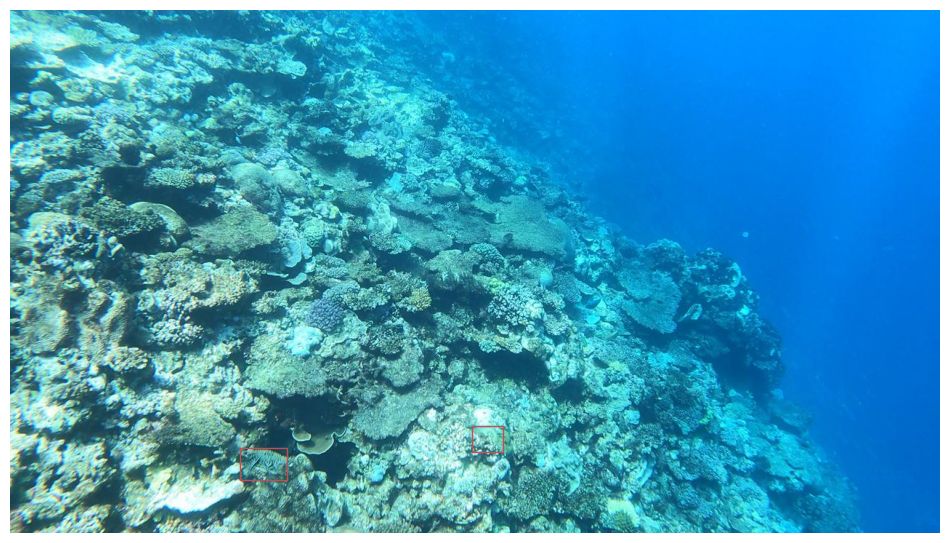

predicted result:
[]


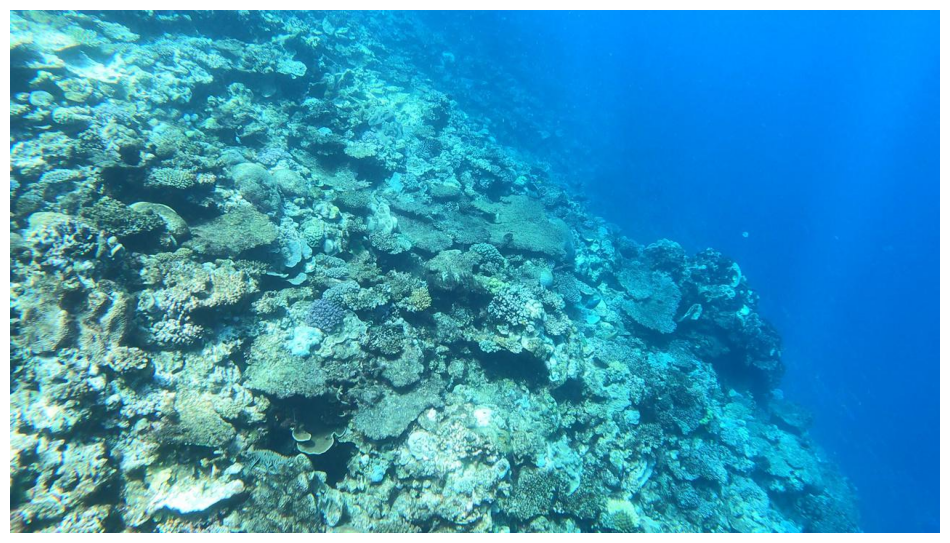

In [54]:
import supervision as sv

detections = sv.Detections.from_ultralytics(results)
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=image, detections=detections)

print("original image:")
bboxes = label_path_to_bbox(label_path, normalized=True)
print(bboxes)
display_image_path_with_label_path(image_path, label_path)


print("predicted result:")
predicted_bboxes = results.boxes.xywhn.tolist()
print(predicted_bboxes)
sv.plot_image(annotated_image)

In [48]:
with open(DATASET_PATH + 'data.yaml', 'r') as f:
    data = yaml.safe_load(f)

# data['names'] = ['starfish']
# data['train'] = DATASET_PATH + 'train/images'
data['val'] = DATASET_PATH + 'test/images'
# data['test'] = DATASET_PATH +'test/images'

with open(DATASET_PATH + 'data.yaml', 'w') as file:
    yaml.dump(data, file, indent=4)

In [49]:
!cat {DATASET_PATH}/'data.yaml'

names:
- starfish
nc: 1
roboflow:
    license: CC BY 4.0
    project: cotskaggle
    url: https://universe.roboflow.com/david-glu/cotskaggle/dataset/1
    version: 1
    workspace: david-glu
test: /kaggle/working/datasets/COTSKaggle-1/test/images
train: /kaggle/working/datasets/COTSKaggle-1/train/images
val: /kaggle/working/datasets/COTSKaggle-1/test/images


In [50]:
# Run validation on a set specified as 'val' argument
metrics = model.val(data=DATASET_PATH + 'data.yaml')

Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/working/datasets/COTSKaggle-1/test/labels... 983 images, 1 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<00:00, 1273.16it/s]

val: New cache created: /kaggle/working/datasets/COTSKaggle-1/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:07<00:00,  8.66it/s]


                   all        983       2237      0.337      0.203      0.167     0.0682
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val


In [51]:
metrics.results_dict

{'metrics/precision(B)': 0.33747967018639613,
 'metrics/recall(B)': 0.20250335270451497,
 'metrics/mAP50(B)': 0.166697393559932,
 'metrics/mAP50-95(B)': 0.06824885116384508,
 'fitness': 0.07809370540345377}

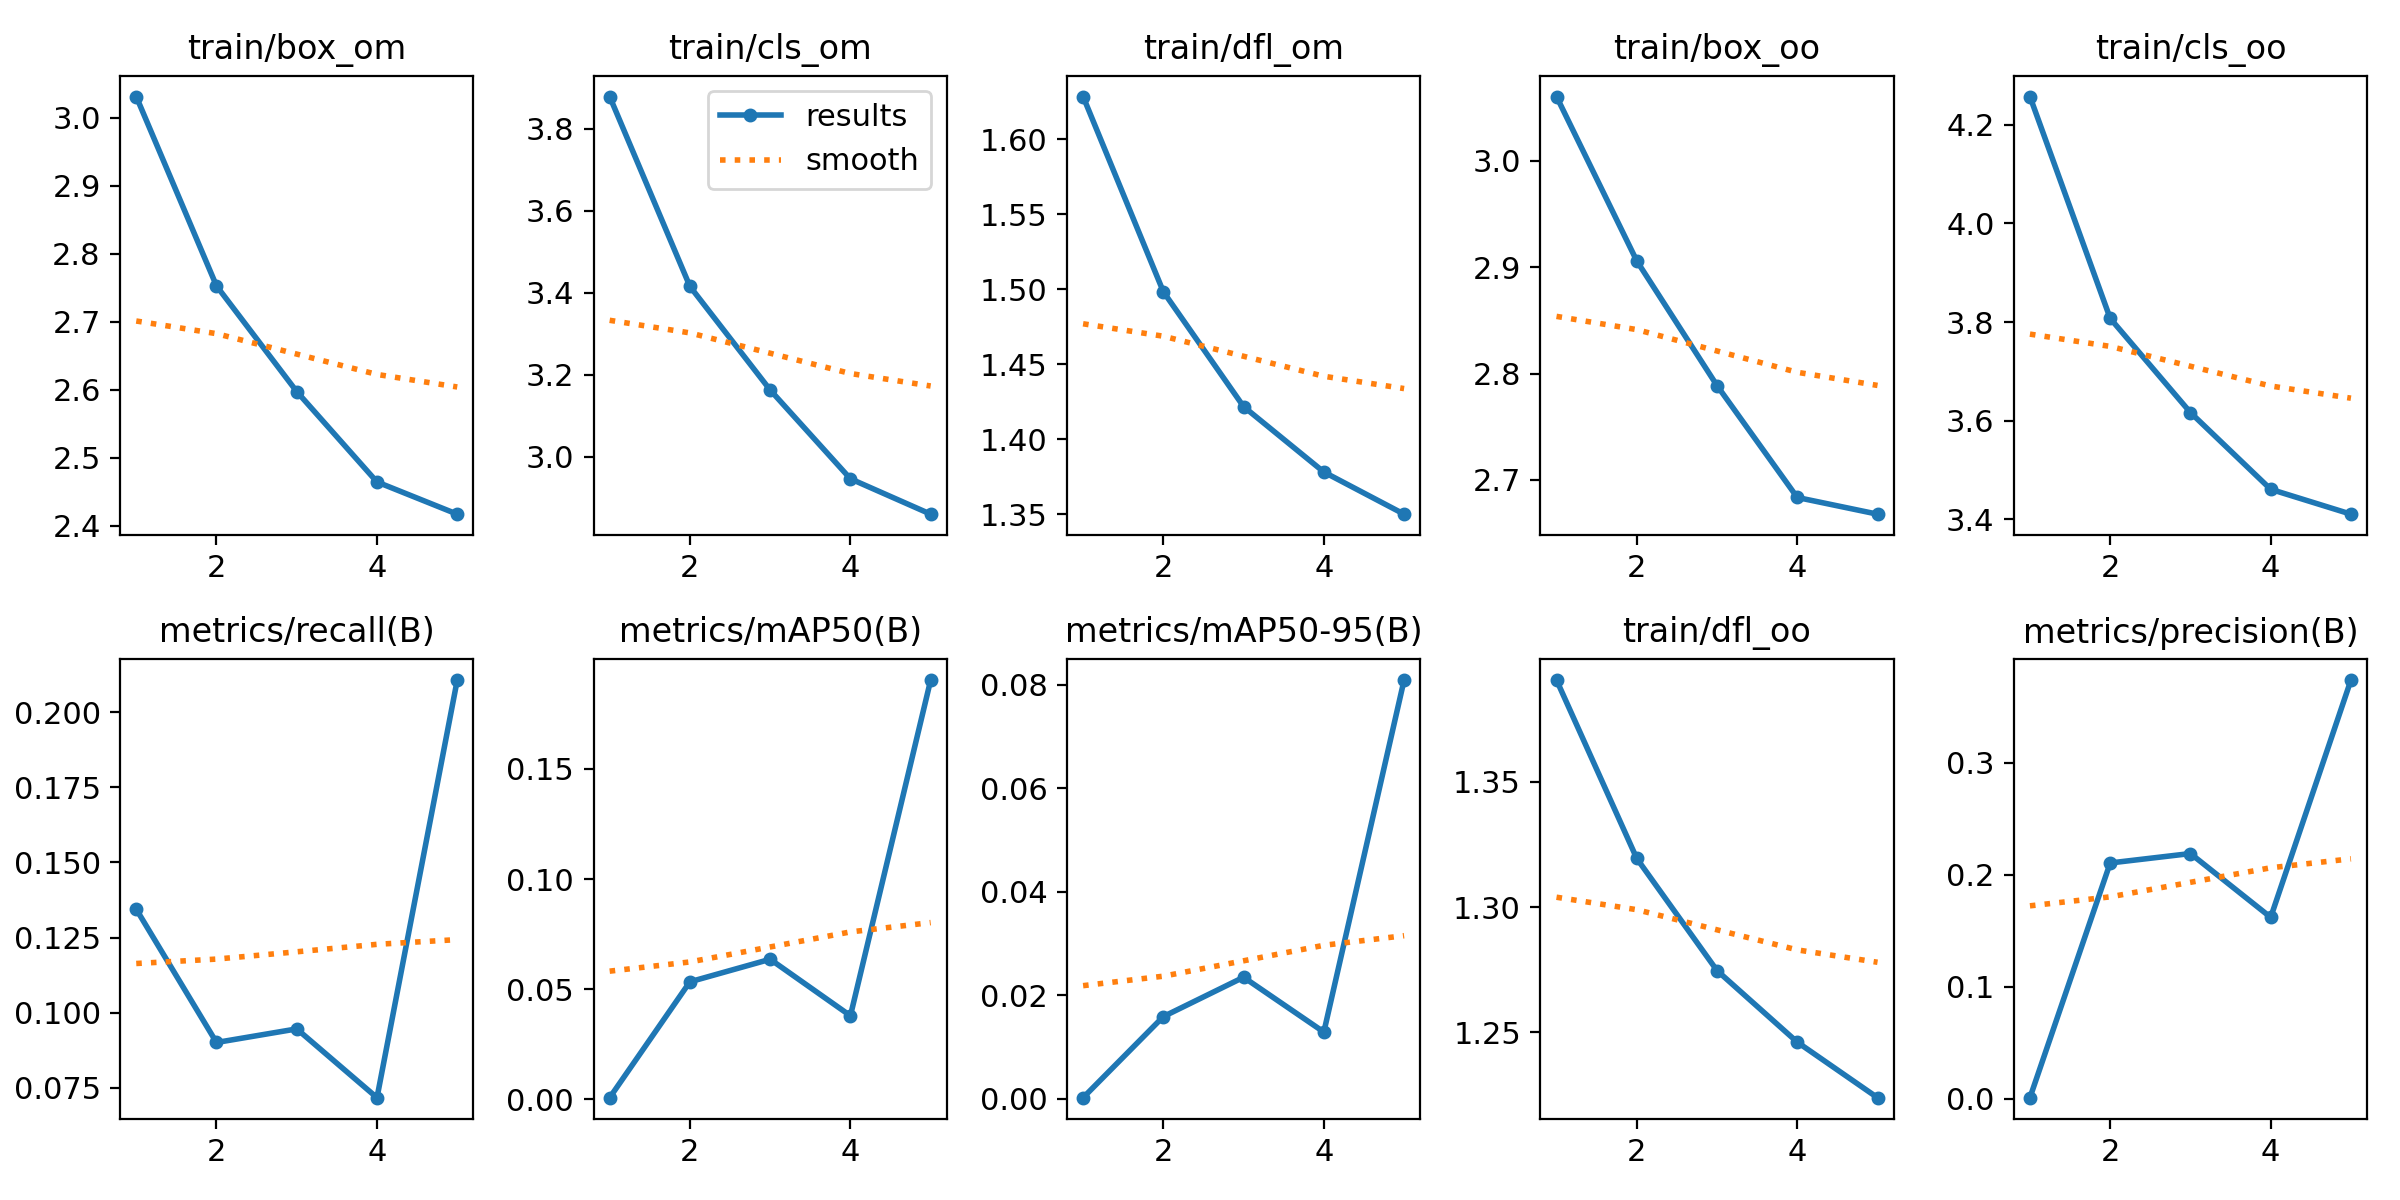

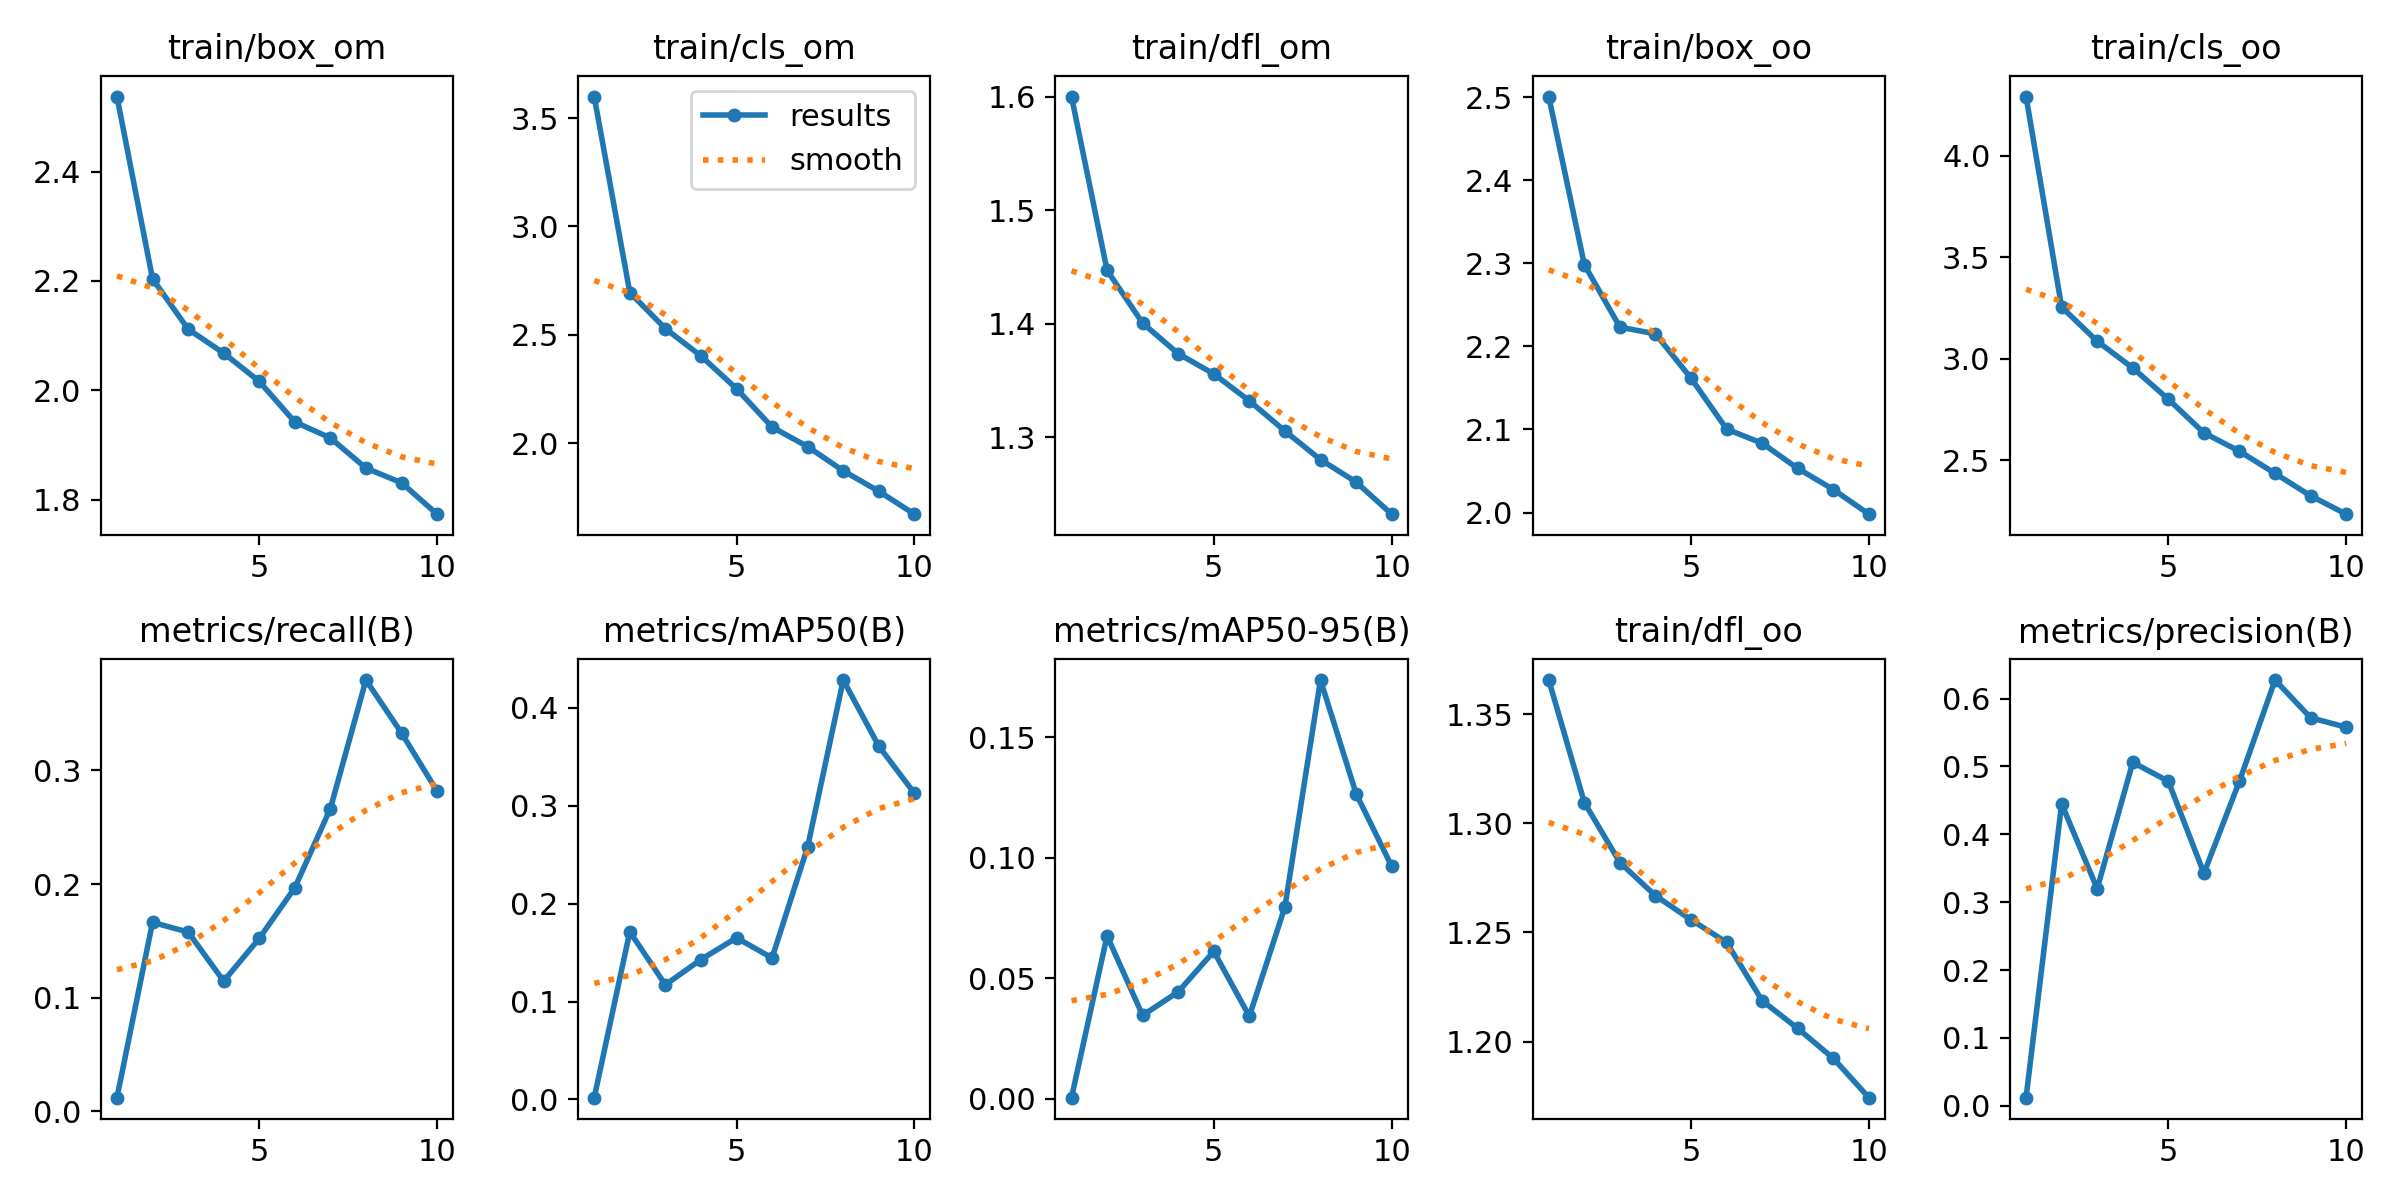

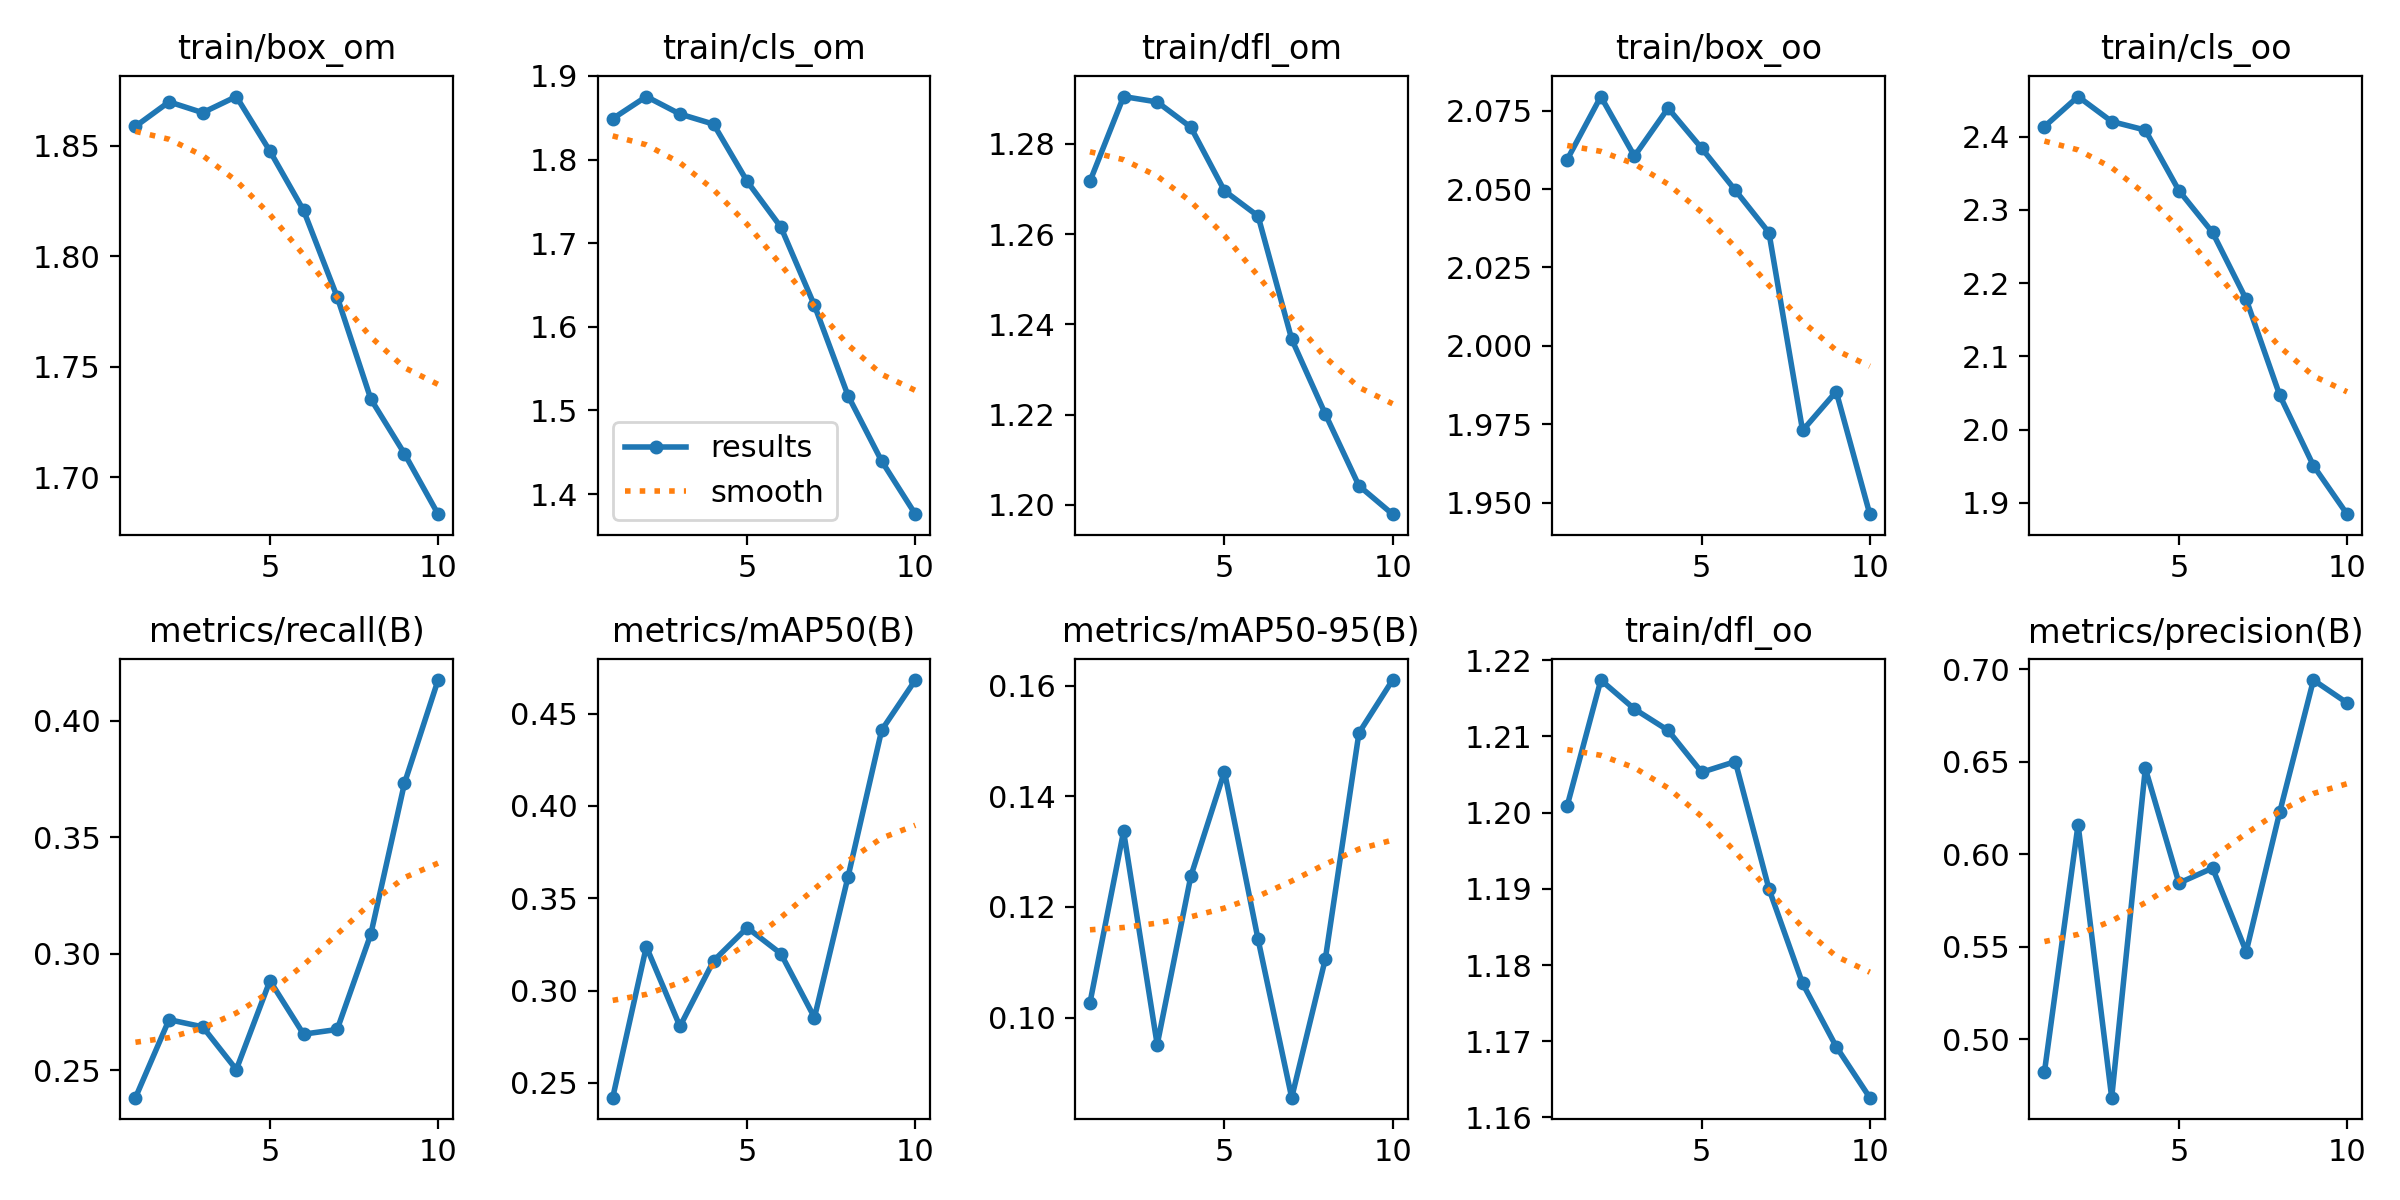

In [58]:
import IPython.display as display


image_res = "/kaggle/working/runs/detect/train/results.png"
res = Image.open(image_res)
display.display(res)

image_res = "/kaggle/working/runs/detect/train2/results.png"
res = Image.open(image_res)
display.display(res)

image_res = "/kaggle/working/runs/detect/train3/results.png"
res = Image.open(image_res)
display.display(res)

In [59]:
!pip install optuna

In [57]:
model = YOLOv10(f'{HOME}/runs/detect/train2/weights/best.pt')
results = model.train(
data=DATASET_PATH + 'data.yaml',
epochs=10,
imgsz=640,
batch=32,
lr0=0.002,
momentum=0.9,
weight_decay=0.0005,
degrees=30.0,
optimizer='AdamW',
patience=10,
augment=True,
hsv_h = 0.015, # image HSV-Hue augmentation (fraction)
hsv_s = 0.7, # image HSV-Saturation augmentation (fraction)
hsv_v = 0.4, # image HSV-Value augmentation (fraction)
translate = 0.0,
scale = 1.0,
fliplr = 0.0,
mosaic = 1.0,
mixup = 0.2,
erasing=0.0,
crop_fraction=0.0    
)

New https://pypi.org/project/ultralytics/8.2.74 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/runs/detect/train2/weights/best.pt, data=/kaggle/working/datasets/COTSKaggle-1/data.yaml, epochs=10, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agno

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/COTSKaggle-1/train/labels.cache... 6972 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6972/6972 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/datasets/COTSKaggle-1/test/labels.cache... 983 images, 1 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       1/10      5.74G      1.859      1.849      1.272      2.059      2.414      1.201         74        640: 100%|██████████| 218/218 [01:36<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


                   all        983       2237      0.482      0.238      0.242      0.103

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       2/10      5.57G       1.87      1.875      1.291      2.079      2.455      1.217         58        640: 100%|██████████| 218/218 [01:32<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]


                   all        983       2237      0.616      0.272      0.324      0.134

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       3/10      5.55G      1.865      1.854      1.289       2.06      2.421      1.214         60        640: 100%|██████████| 218/218 [01:29<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]


                   all        983       2237      0.468      0.269      0.281     0.0951

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       4/10      5.48G      1.872      1.842      1.284      2.076      2.409      1.211         63        640: 100%|██████████| 218/218 [01:30<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


                   all        983       2237      0.646       0.25      0.316      0.126

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       5/10      5.47G      1.848      1.774       1.27      2.063      2.326      1.205         54        640: 100%|██████████| 218/218 [01:30<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]


                   all        983       2237      0.584      0.288      0.334      0.144

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       6/10       5.5G      1.821      1.719      1.264       2.05      2.269      1.207         64        640: 100%|██████████| 218/218 [01:30<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]


                   all        983       2237      0.592      0.266       0.32      0.114

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/10      5.48G      1.782      1.626      1.237      2.036      2.178       1.19         49        640: 100%|██████████| 218/218 [01:29<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]


                   all        983       2237      0.547      0.268      0.285     0.0855

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       8/10      5.52G      1.735      1.518       1.22      1.973      2.047      1.178         35        640: 100%|██████████| 218/218 [01:30<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]


                   all        983       2237      0.623      0.308      0.362      0.111

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       9/10       5.5G      1.711      1.439      1.204      1.985      1.951      1.169         67        640: 100%|██████████| 218/218 [01:30<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]


                   all        983       2237      0.694      0.373      0.441      0.151

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      10/10       5.5G      1.683      1.376      1.198      1.946      1.885      1.163         77        640: 100%|██████████| 218/218 [01:30<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


                   all        983       2237      0.682      0.418      0.468      0.161

10 epochs completed in 0.282 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 5.7MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


                   all        983       2237      0.481      0.405      0.365      0.134
Speed: 0.1ms preprocess, 4.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/train3


In [ ]:
!pip install optuna

In [65]:
import optuna
import subprocess
import yaml
import os

# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.002)
    momentum = trial.suggest_uniform('momentum', 0.85, 0.95)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
    hsv_h = trial.suggest_uniform('hsv_h', 0.0, 0.5)
    hsv_s = trial.suggest_uniform('hsv_s', 0.0, 0.5)
    hsv_v = trial.suggest_uniform('hsv_v', 0.0, 0.5)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSProp", "AdamW"])
    augment = trial.suggest_categorical('augment', [True, False])

    model = YOLOv10(f'{HOME}/weights/yolov10n.pt')
    results = model.train(
    data=DATASET_PATH + 'data.yaml',
    epochs=1,
    imgsz=640,
    batch=32,
    lr0=learning_rate,
    momentum=momentum,
    weight_decay=weight_decay,
    degrees=30.0,
    optimizer=optimizer_name,
    patience=10,
    augment=augment,
    hsv_h = hsv_h, # image HSV-Hue augmentation (fraction)
    hsv_s = hsv_s, # image HSV-Saturation augmentation (fraction)
    hsv_v = hsv_v, # image HSV-Value augmentation (fraction)
    translate = 0.0,
    scale = 1.0,
    fliplr = 0.0,
    mosaic = 1.0,
    mixup = 0.2,
    erasing=0.0,
    crop_fraction=0.0    
    )
    metrics = model.val(data=DATASET_PATH + 'data.yaml')
    fitness = 0.2 * metrics.results_dict['metrics/recall(B)'] + 0.2 * metrics.results_dict['metrics/mAP50(B)'] + 0.6 * metrics.results_dict['metrics/mAP50-95(B)'] 
    val_loss = fitness # Run validation on a set specified as 'val' argument
    
    return val_loss

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Get the best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-08-06 12:05:31,369] A new study created in memory with name: no-name-4d3d6a4d-7847-4d77-9f89-e5914bfc1b81


New https://pypi.org/project/ultralytics/8.2.74 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10n.pt, data=/kaggle/working/datasets/COTSKaggle-1/data.yaml, epochs=1, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=RMSProp, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False

train: Scanning /kaggle/working/datasets/COTSKaggle-1/train/labels.cache... 6972 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6972/6972 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/datasets/COTSKaggle-1/test/labels.cache... 983 images, 1 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: RMSprop(lr=0.004671807908155812, momentum=0.9060240524945744) with parameter groups 95 weight(decay=0.0), 108 weight(decay=5.9234629475009005e-05), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train7
Starting training for 1 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        1/1      10.9G      3.673      4.365       1.79      3.443      4.639      1.527        122        640: 100%|██████████| 218/218 [01:40<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


                   all        983       2237   9.83e-05    0.00134   5.41e-05   8.84e-06

1 epochs completed in 0.042 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 5.7MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


                   all        983       2237   8.84e-05    0.00134    4.7e-05   9.14e-06
Speed: 0.1ms preprocess, 4.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train7


Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /kaggle/working/datasets/COTSKaggle-1/test/labels.cache... 983 images, 1 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.33it/s]


                   all        983       2237   8.84e-05    0.00134    4.7e-05   9.14e-06
Speed: 0.1ms preprocess, 4.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/train72


[I 2024-08-06 12:08:46,092] Trial 0 finished with value: 0.00028310744067785467 and parameters: {'learning_rate': 0.004671807908155812, 'momentum': 0.9060240524945744, 'weight_decay': 5.9234629475009005e-05, 'hsv_h': 0.29654890649397014, 'hsv_s': 0.014240318392183593, 'hsv_v': 0.2583356946669328, 'optimizer': 'RMSProp'}. Best is trial 0 with value: 0.00028310744067785467.


New https://pypi.org/project/ultralytics/8.2.74 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10n.pt, data=/kaggle/working/datasets/COTSKaggle-1/data.yaml, epochs=1, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, 

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/COTSKaggle-1/train/labels.cache... 6972 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6972/6972 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/datasets/COTSKaggle-1/test/labels.cache... 983 images, 1 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs/detect/train8/labels.jpg... 
optimizer: AdamW(lr=0.0058278103461082585, momentum=0.8678591009560844) with parameter groups 95 weight(decay=0.0), 108 weight(decay=2.0528098148955554e-05), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train8
Starting training for 1 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        1/1      10.9G      2.839      3.588      1.552      2.915      4.046      1.361        122        640: 100%|██████████| 218/218 [01:41<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.28it/s]


                   all        983       2237      0.237    0.00849    0.00735    0.00359

1 epochs completed in 0.042 hours.
Optimizer stripped from runs/detect/train8/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train8/weights/best.pt, 5.7MB

Validating runs/detect/train8/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


                   all        983       2237      0.181     0.0139    0.00954    0.00495
Speed: 0.1ms preprocess, 4.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/train8


Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /kaggle/working/datasets/COTSKaggle-1/test/labels.cache... 983 images, 1 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.67it/s]


                   all        983       2237      0.181     0.0139    0.00954    0.00495
Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/train82


[I 2024-08-06 12:13:18,588] Trial 1 finished with value: 0.007651573917178832 and parameters: {'learning_rate': 0.0058278103461082585, 'momentum': 0.8678591009560844, 'weight_decay': 2.0528098148955554e-05, 'hsv_h': 0.0001821415484651867, 'hsv_s': 0.3368285248002455, 'hsv_v': 0.09133336406016707, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.007651573917178832.


New https://pypi.org/project/ultralytics/8.2.74 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10n.pt, data=/kaggle/working/datasets/COTSKaggle-1/data.yaml, epochs=1, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, c

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/COTSKaggle-1/train/labels.cache... 6972 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6972/6972 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/datasets/COTSKaggle-1/test/labels.cache... 983 images, 1 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: Adam(lr=3.9380610082732074e-05, momentum=0.8871592033965158) with parameter groups 95 weight(decay=0.0), 108 weight(decay=2.5917840557210903e-06), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train9
Starting training for 1 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        1/1      10.9G      2.975      3.907      1.585      2.977      4.307      1.341        122        640: 100%|██████████| 218/218 [01:41<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


                   all        983       2237    0.00269      0.354    0.00906    0.00297

1 epochs completed in 0.059 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 5.7MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


                   all        983       2237    0.00243      0.321    0.00776    0.00256
Speed: 0.1ms preprocess, 4.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/train9


Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /kaggle/working/datasets/COTSKaggle-1/test/labels.cache... 983 images, 1 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.63it/s]


                   all        983       2237    0.00243      0.321    0.00776    0.00256
Speed: 0.1ms preprocess, 4.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/train92


[I 2024-08-06 12:17:51,297] Trial 2 finished with value: 0.06719390220947861 and parameters: {'learning_rate': 3.9380610082732074e-05, 'momentum': 0.8871592033965158, 'weight_decay': 2.5917840557210903e-06, 'hsv_h': 0.361246888745447, 'hsv_s': 0.38678112025829253, 'hsv_v': 0.032321889432089024, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.06719390220947861.


New https://pypi.org/project/ultralytics/8.2.74 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10n.pt, data=/kaggle/working/datasets/COTSKaggle-1/data.yaml, epochs=1, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, 

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/COTSKaggle-1/train/labels.cache... 6972 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6972/6972 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/datasets/COTSKaggle-1/test/labels.cache... 983 images, 1 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs/detect/train10/labels.jpg... 
optimizer: Adam(lr=0.004534194118356414, momentum=0.8841377083672871) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005059906601191097), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train10
Starting training for 1 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        1/1        11G      2.888      3.676      1.602      2.953       4.11      1.384        122        640: 100%|██████████| 218/218 [02:43<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]


                   all        983       2237     0.0888      0.037     0.0171    0.00631

1 epochs completed in 0.060 hours.
Optimizer stripped from runs/detect/train10/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train10/weights/best.pt, 5.7MB

Validating runs/detect/train10/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


                   all        983       2237     0.0596     0.0407     0.0144    0.00558
Speed: 0.1ms preprocess, 4.6ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train10


Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /kaggle/working/datasets/COTSKaggle-1/test/labels.cache... 983 images, 1 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.16it/s]


                   all        983       2237     0.0596     0.0407     0.0144    0.00558
Speed: 0.1ms preprocess, 5.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/train102


[I 2024-08-06 12:22:27,916] Trial 3 finished with value: 0.0143585151136952 and parameters: {'learning_rate': 0.004534194118356414, 'momentum': 0.8841377083672871, 'weight_decay': 0.0005059906601191097, 'hsv_h': 0.24163680257810444, 'hsv_s': 0.2527871293233208, 'hsv_v': 0.06567243333606038, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.06719390220947861.


New https://pypi.org/project/ultralytics/8.2.74 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10n.pt, data=/kaggle/working/datasets/COTSKaggle-1/data.yaml, epochs=1, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=RMSProp, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=Fals

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/COTSKaggle-1/train/labels.cache... 6972 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6972/6972 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/datasets/COTSKaggle-1/test/labels.cache... 983 images, 1 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs/detect/train11/labels.jpg... 
optimizer: RMSprop(lr=0.0018023798976818176, momentum=0.8885496064163817) with parameter groups 95 weight(decay=0.0), 108 weight(decay=8.126668116597503e-06), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train11
Starting training for 1 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


        1/1        11G      3.508      4.273      1.749      3.379      4.555       1.52        122        640: 100%|██████████| 218/218 [01:41<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.29it/s]


                   all        983       2237   2.37e-05    0.00313   1.37e-05   2.58e-06

1 epochs completed in 0.059 hours.
Optimizer stripped from runs/detect/train11/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train11/weights/best.pt, 5.7MB

Validating runs/detect/train11/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  2.00it/s]


                   all        983       2237   4.07e-05    0.00536   2.18e-05   4.71e-06
Speed: 0.1ms preprocess, 4.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/train11


Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /kaggle/working/datasets/COTSKaggle-1/test/labels.cache... 983 images, 1 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.66it/s]


                   all        983       2237   4.07e-05    0.00536   2.18e-05   4.71e-06
Speed: 0.1ms preprocess, 4.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/train112


[I 2024-08-06 12:27:00,329] Trial 4 finished with value: 0.0010800512105214532 and parameters: {'learning_rate': 0.0018023798976818176, 'momentum': 0.8885496064163817, 'weight_decay': 8.126668116597503e-06, 'hsv_h': 0.49568366455043733, 'hsv_s': 0.05086217128900655, 'hsv_v': 0.02300479740947514, 'optimizer': 'RMSProp'}. Best is trial 2 with value: 0.06719390220947861.


Best hyperparameters:  {'learning_rate': 3.9380610082732074e-05, 'momentum': 0.8871592033965158, 'weight_decay': 2.5917840557210903e-06, 'hsv_h': 0.361246888745447, 'hsv_s': 0.38678112025829253, 'hsv_v': 0.032321889432089024, 'optimizer': 'Adam'}


In [66]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
print("Study statistics: ")
print(" Number of finished trials: ", len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

Study statistics: 
 Number of finished trials:  5
 Number of pruned trials:  0
 Number of complete trials:  5
Best trial:
 Value:  0.06719390220947861
 Params: 
 learning_rate: 3.9380610082732074e-05
 momentum: 0.8871592033965158
 weight_decay: 2.5917840557210903e-06
 hsv_h: 0.361246888745447
 hsv_s: 0.38678112025829253
 hsv_v: 0.032321889432089024
 optimizer: Adam


In [68]:
optuna.visualization.plot_param_importances(study)

ValueError: Parameter n_units_l0 does not exist in your study.